In [25]:
import sys
if 'google.colab' in sys.modules:
    import os

    # Undo the recent upgrade of importlib-metadata
    ## Thanks to @Mxhiu: https://stackoverflow.com/a/73932581/14473118
    os.system("pip install -q importlib-metadata==4.13.0")
    os.system('apt-get install -y xvfb')
    os.system('wget https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/xvfb -O ../xvfb')
    # Download `atari_wrappers.py` script from github
    os.system("wget https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week06_policy_based/atari_wrappers.py")
    # Download `env_batch.py` script from github    
    os.system("wget https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week06_policy_based/env_batch.py")
    # Download `runners.py` script from github    
    os.system("wget https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week06_policy_based/runners.py")
    
    os.system('apt-get install -y python-opengl ffmpeg')
    os.system('pip install pyglet==1.2.4')
    # Update the gym environment to be compatible with the atari environment.
    os.system('pip install gym[atari,accept-rom-license]==0.21.0')
    os.system('python -m pip install -U pygame --user')

    print('setup complete')

# XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

# Implementing Advantage-Actor Critic (A2C)

In this notebook you will implement Advantage Actor Critic algorithm that trains on a batch of Atari 2600 environments running in parallel.

Firstly, we will use environment wrappers implemented in file `atari_wrappers.py`. These wrappers preprocess observations (resize, grayscale, take max between frames, skip frames and stack them together) and rewards. Some of the wrappers help to reset the environment and pass `done` flag equal to `True` when agent dies.
File `env_batch.py` includes implementation of `ParallelEnvBatch` class that allows to run multiple environments in parallel. To create an environment we can use `nature_dqn_env` function. Note that if you are using
PyTorch and not using `tensorboardX` you will need to implement a wrapper that will log **raw** total rewards that the *unwrapped* environment returns and redefine the implemention of `nature_dqn_env` function here.



In [1]:
import numpy as np
from atari_wrappers import nature_dqn_env, NumpySummaries


env = nature_dqn_env("SpaceInvadersNoFrameskip-v4", nenvs=8, summaries='Numpy')
obs = env.reset()
assert obs.shape == (8, 84, 84, 4)
assert obs.dtype == np.uint8

A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]


In [2]:
n_actions = env.action_space.n

Next, we will need to implement a model that predicts logits and values. It is suggested that you use the same model as in [Nature DQN paper](https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf) with a modification that instead of having a single output layer, it will have two output layers taking as input the output of the last hidden layer. **Note** that this model is different from the model you used in homework where you implemented DQN. You can use your favorite deep learning framework here. We suggest that you use orthogonal initialization with parameter $\sqrt{2}$ for kernels and initialize biases with zeros.

In [3]:
# import tensorflow as torch
# import torch as tf

import torch
import torch.nn as nn

class Agent(torch.nn.Module):
    def __init__(self):
        super(Agent, self).__init__()
        self.agent = nn.Sequential(
            nn.Conv2d(4, 32, (8, 8), stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, (4, 4), stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, (3, 3), stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions + 1),
        )

        for p in self.agent:
            if hasattr(p, "weight"):
                nn.init.orthogonal_(p.weight, gain=np.sqrt(2))
            if hasattr(p, "bias"):
                nn.init.zeros_(p.bias)
                
    def forward(self, input_):
        return self.agent(input_)

You will also need to define and use a policy that wraps the model. While the model computes logits for all actions, the policy will sample actions and also compute their log probabilities.  `policy.act` should return a dictionary of all the arrays that are needed to interact with an environment and train the model.
 Note that actions must be an `np.ndarray` while the other
tensors need to have the type determined by your deep learning framework.

In [4]:
import torch.nn.functional as F

class Policy:
    def __init__(self, model):
        self.model = model

    def act(self, inputs):
        # <Implement policy by calling model, sampling actions and computing their log probs>
        # Should return a dict containing keys ['actions', 'logits', 'log_probs', 'values'].
        inputs = torch.tensor(inputs / 255, dtype=torch.float32).permute(0, 3, 1, 2)
        output = self.model(inputs)
        logits = output[:, :-1]
        values = output[:, -1]
        return {
            "actions": np.array([np.random.choice(n_actions, p=F.softmax(logits[i].detach(), dim=-1).numpy()) for i in range(logits.shape[0])]),
            "logits": logits,
            "log_probs": F.log_softmax(logits, dim=-1),
            "values": values,
            "probs": F.softmax(logits, dim=-1)
        }

Next will pass the environment and policy to a runner that collects partial trajectories from the environment.
The class that does is is already implemented for you.

In [5]:
from runners import EnvRunner

This runner interacts with the environment for a given number of steps and returns a dictionary containing
keys

* 'observations'
* 'rewards'
* 'resets'
* 'actions'
* all other keys that you defined in `Policy`

under each of these keys there is a python `list` of interactions with the environment. This list has length $T$ that is size of partial trajectory. Partial trajectory for given moment `t` is part of `ComputeValueTargets.__call__` input argument `trajectory` from moment `t` to the end (i.e. it's different at each iteration in the algorithm).

To train the part of the model that predicts state values you will need to compute the value targets.
Any callable could be passed to `EnvRunner` to be applied to each partial trajectory after it is collected.
Thus, we can implement and use `ComputeValueTargets` callable.
The formula for the value targets is simple:

$$
\hat v(s_t) = \left( \sum_{t'=0}^{T - 1} \gamma^{t'}r_{t+t'} \right) + \gamma^T \hat{v}(s_{t+T}),
$$

In implementation, however, do not forget to use
`trajectory['resets']` flags to check if you need to add the value targets at the next step when
computing value targets for the current step. You can access `trajectory['state']['latest_observation']`
to get last observations in partial trajectory &mdash; $s_{t+T}$.

In [6]:
class ComputeValueTargets:
    def __init__(self, policy, gamma=0.99):
        self.policy = policy
        self.gamma = gamma

    def __call__(self, trajectory):
        # This method should modify trajectory inplace by adding
        # an item with key 'value_targets' to it.
        s_last = trajectory['state']['latest_observation']
        with torch.no_grad():
            v_s_last = self.policy.act(s_last)['values'].detach().cpu().numpy()

        value_targets = []
        
        for t in range(len(trajectory['rewards']) - 1, -1, -1):
            value_targets.append(trajectory['rewards'][t] +
                                 (self.gamma * (value_targets[-1] if len(value_targets) > 0 else v_s_last)) * 
                                  (1 - trajectory['resets'][t]))

        trajectory['value_targets'] = list(reversed(value_targets))

After computing value targets we will transform lists of interactions into tensors
with the first dimension `batch_size` which is equal to `env_steps * nenvs`, i.e. you essentially need
to flatten the first two dimensions.

In [7]:
class MergeTimeBatch:
    """ Merges first two axes typically representing time and env batch. """
    def __call__(self, trajectory):
        # Modify trajectory inplace.
        for item in trajectory:
            if item == "state":
                continue
            if type(trajectory[item][0]) != torch.Tensor:
                item_value = np.array(trajectory[item])
            else:
                item_value = torch.stack(trajectory[item])
            cur_shape = item_value.shape
            trajectory[item] = item_value.reshape((
                cur_shape[0] * cur_shape[1], *cur_shape[2:]
            ))

In [8]:
model = Agent()
policy = Policy(model)
runner = EnvRunner(
    env, policy, nsteps=5,
    transforms=[
        ComputeValueTargets(policy),
        MergeTimeBatch(),
    ])

Now is the time to implement the advantage actor critic algorithm itself. You can look into your lecture,
[Mnih et al. 2016](https://arxiv.org/abs/1602.01783) paper, and [lecture](https://www.youtube.com/watch?v=Tol_jw5hWnI&list=PLkFD6_40KJIxJMR-j5A1mkxK26gh_qg37&index=20) by Sergey Levine.

In [9]:
class A2C:
    def __init__(self,
                 policy,
                 optimizer,
                 value_loss_coef=0.25,
                 entropy_coef=0.01,
                 max_grad_norm=0.5):
        self.policy = policy
        self.optimizer = optimizer
        self.value_loss_coef = value_loss_coef
        self.entropy_coef = entropy_coef
        self.max_grad_norm = max_grad_norm
        
    def advantage(self, trajectory):
        return torch.tensor(trajectory['value_targets']) - trajectory['values'].detach()

    def policy_loss(self, trajectory):
        # You will need to compute advantages here.
        grads = trajectory['log_probs'][np.arange(len(trajectory['actions'])), trajectory['actions']]
        advantage = self.advantage(trajectory)
        return -torch.mean(grads * advantage)

    def value_loss(self, trajectory):
        return F.mse_loss(trajectory['values'], torch.tensor(trajectory['value_targets'], dtype=torch.float32))

    def entropy(self, trajectory):
        return  - torch.mean(torch.sum(trajectory['log_probs'] * trajectory['probs'], dim=-1))
    
    def loss(self, trajectory):
        return self.policy_loss(trajectory) + self.value_loss_coef * self.value_loss(trajectory) - \
                    self.entropy_coef * self.entropy(trajectory)

    def step(self, trajectory):
        self.optimizer.zero_grad()
        loss = self.loss(trajectory)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy.model.parameters(), self.max_grad_norm)
        self.optimizer.step()

Now you can train your model. With reasonable hyperparameters training on a single GTX1080 for 10 million steps across all batched environments (which translates to about 5 hours of wall clock time)
it should be possible to achieve *average raw reward over last 100 episodes* (the average is taken over 100 last
episodes in each environment in the batch) of about 600. You should plot this quantity with respect to
`runner.step_var` &mdash; the number of interactions with all environments. It is highly
encouraged to also provide plots of the following quantities (these are useful for debugging as well):

* [Coefficient of Determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) between
value targets and value predictions
* Entropy of the policy $\pi$
* Value loss
* Policy loss
* Value targets
* Value predictions
* Gradient norm
* Advantages
* A2C loss

For optimization we suggest you use RMSProp with learning rate starting from 7e-4 and linearly decayed to 0, smoothing constant (alpha in PyTorch and decay in TensorFlow) equal to 0.99 and epsilon equal to 1e-5.

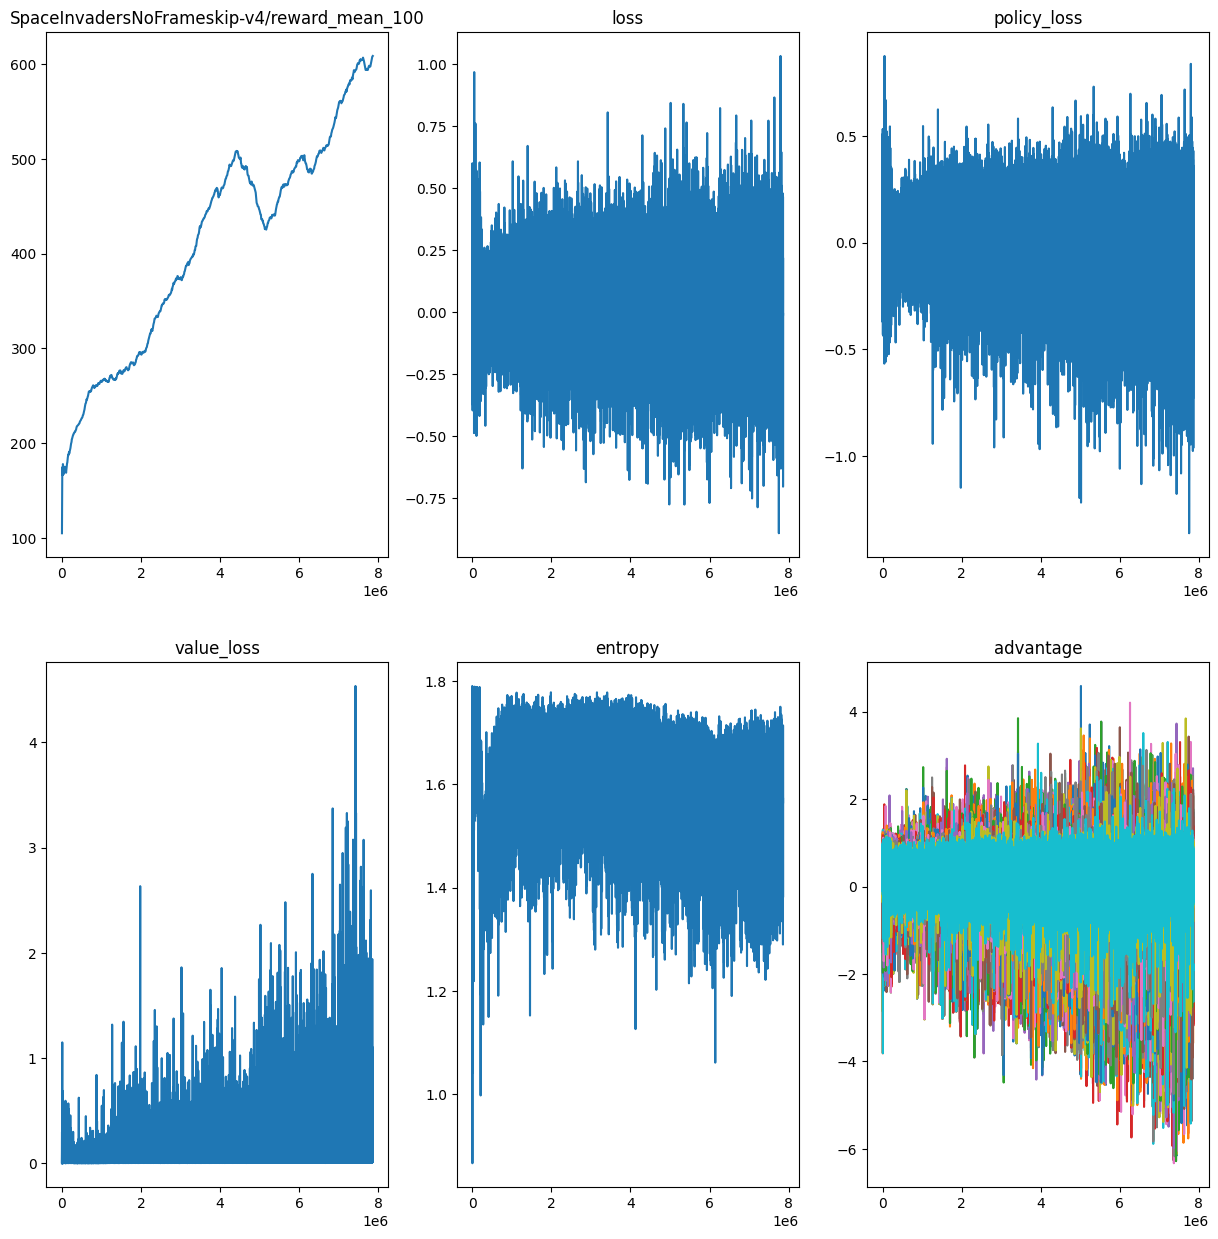

 79%|███████▊  | 196517/250000 [7:08:55<1:56:43,  7.64it/s] 


KeyboardInterrupt: 

In [10]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import pickle


nenvs = 8
nsteps = 5
max_iters = 250000
log_iter = 100

env.reset()

model = Agent()
policy = Policy(model)
runner = EnvRunner(
    env, policy, nsteps=nsteps,
    transforms=[
        ComputeValueTargets(policy),
        MergeTimeBatch(),
    ])

optimizer = torch.optim.RMSprop(model.parameters(), lr=7e-4, alpha=0.99, eps=1e-5)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, end_factor=0, start_factor=1, total_iters=max_iters)

a2c = A2C(policy, optimizer)

for i in tqdm(range(0, max_iters)):
    NumpySummaries.set_step(runner.step_var)
    trajectory = runner.get_next()

    a2c.step(trajectory)
    scheduler.step()
    
    env.add_summary_scalar("loss", a2c.loss(trajectory).detach().cpu().numpy())
    env.add_summary_scalar("policy_loss", a2c.policy_loss(trajectory).detach().cpu().numpy())
    env.add_summary_scalar("value_loss", a2c.value_loss(trajectory).detach().cpu().numpy())
    env.add_summary_scalar("entropy", a2c.entropy(trajectory).detach().cpu().numpy())
    env.add_summary_scalar("advantage", a2c.advantage(trajectory).detach().cpu().numpy())
    
    if (i + 1) % log_iter == 0:
        clear_output()
        f, axs = plt.subplots(2, 3, figsize=(15, 15))
        
        def plot_summary(name, ax):
            summary = NumpySummaries.get_values(name)
            ax.plot([a for a, b in summary], [b for a, b in summary])
            #with open(f"{name.replace('/', '')}-saved-{i}.pkl", "wb") as f:
            #    pickle.dump(summary, f)
            ax.set_title(name)
            
        names = ["SpaceInvadersNoFrameskip-v4/reward_mean_100",
                "loss",
                "policy_loss",
                "value_loss",
                "entropy",
                "advantage"]
        plot_axs = [axs[i][j] for i in range(2) for j in range(3)]

        for name, ax in zip(names, plot_axs):
            plot_summary(name, ax)
        plt.show()

Стопнула, как только mean_raw_reward добежал до 600.

### Target networks?

You may recall a technique called "target networks" we used a few weeks ago when we trained a DQN agent to play Atari Breakout and wonder why we have not suggested using them here. The answer is that this is more historical than practical.

While the "chasing the target" problem is still present in actor-critic value estimation and target networks do show up in follow-up papers, the original A3C/A2C papers do not mention them and do not explain this omission.

The hypothesis why this may not be a big deal (compared to Q-learning) goes like this. An A3C/A2C agent selects actions based on policy, not an epsilon greedy exploration function, for which the argmax can change drastically due to tiny errors in function approximation. Therefore, errors in the value target caused by target chasing will cause less damage.

Also, the actor-critic gradient relies on the advantage function $A(s_t, a_t) = Q(s_t, a_t) - V(s_t)$. Compare this to the $Q$-function $Q(s_t, a_t) = r(s_t, a_t) + \gamma \cdot \mathbb{E}_{s_{t+1} \mid s_t, a_t} V(s_{t+1})$ used in Q-learning and SARSA: we would expect that any bias in $V$-function approximation will be carried over from $V(s_{t+1})$ to $V(s_t)$ by gradient updates. However, in the formula for the advantage function the two approximations ($Q$-function and $V$-function) come with opposite signs, and thus the errors will cancel out.

The last reason may be computational. Authors were concerned to beat existent algorithms in the wall-clock learning time, and any overhead of parameter copying (target network update) counted against this goal.